In [1]:
import numpy as np
import cv2
from scipy.optimize import lsq_linear
# from jetbot import Robot, Camera, bgr8_to_jpeg
from IPython.display import display, Image, clear_output

def bgr8_to_jpeg(image, quality=90):
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Invalid image for JPEG encoding")

    if image.dtype != np.uint8:
        image = np.clip(image, 0, 255).astype(np.uint8)

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    encode_params = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    success, jpeg = cv2.imencode('.jpg', image, encode_params)
    if not success:
        raise ValueError("JPEG encoding failed")
    return jpeg.tobytes()


In [2]:
import cv2
import numpy as np

def get_lane_curve_poly(image):
    # Preprocessing
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask_white = cv2.inRange(hsv, (0, 0, 160), (255, 40, 255))  # Detect white line
    mask_yellow = cv2.inRange(hsv, (20, 100, 100), (30, 255, 255))  # Detect yellow
    mask = cv2.bitwise_or(mask_white, mask_yellow)

    # Morphology to clean up
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    # Contour detection
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if not contours:
        return None, image

    # Find largest contour
    contour = max(contours, key=cv2.contourArea)

    # Fit polynomial
    pts = contour.squeeze()
    if pts.ndim != 2 or pts.shape[0] < 5:
        return None, image

    try:
        # Fit y = ax^2 + bx + c (x is horizontal)
        poly = np.polyfit(pts[:, 1], pts[:, 0], 2)  # x as function of y

        # Draw the fitted curve
        fitted_img = image.copy()
        for y in range(0, image.shape[0], 5):
            x = int(poly[0] * y ** 2 + poly[1] * y + poly[2])
            if 0 <= x < image.shape[1]:
                cv2.circle(fitted_img, (x, y), 2, (0, 255, 0), -1)
        return poly, fitted_img

    except Exception as e:
        print("Fit failed:", e)
        return None, image


In [3]:
import cv2
import numpy as np
# from jetbot import Robot, Camera
import time

# robot = Robot()
# camera = Camera.instance(width=224, height=224)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [vertices], 255)
    masked = cv2.bitwise_and(img, mask)
    return masked

def get_lane_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    height, width = edges.shape
    roi_vertices = np.array([[
        (0, height),
        (width * 0.4, height * 0.6),
        (width * 0.6, height * 0.6),
        (width, height)
    ]], dtype=np.int32)

    cropped = region_of_interest(edges, roi_vertices[0])
    lines = cv2.HoughLinesP(cropped, 1, np.pi / 180, threshold=50, minLineLength=20, maxLineGap=200)
    
    return lines

def calculate_deviation(image, lines):
    if lines is None:
        return 0.0, False

    height, width, _ = image.shape
    mid = width // 2

    left_lines = []
    right_lines = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0:
            continue
        slope = (y2 - y1) / (x2 - x1)
        if abs(slope) < 0.5:
            continue
        if slope < 0:
            left_lines.append((x1, y1, x2, y2))
        else:
            right_lines.append((x1, y1, x2, y2))

    if not left_lines and not right_lines:
        return 0.0, False

    def average_line(lines):
        x1s, y1s, x2s, y2s = zip(*lines)
        return int(np.mean(x1s)), int(np.mean(y1s)), int(np.mean(x2s)), int(np.mean(y2s))

    if left_lines:
        x1_l, y1_l, x2_l, y2_l = average_line(left_lines)
        x_l = (x1_l + x2_l) // 2
    else:
        x_l = 0

    if right_lines:
        x1_r, y1_r, x2_r, y2_r = average_line(right_lines)
        x_r = (x1_r + x2_r) // 2
    else:
        x_r = width

    lane_center = (x_l + x_r) // 2
    deviation = (lane_center - mid) / mid
    return deviation, True

# def follow_lane():
#     try:
#         while True:
#             image = camera.value
#             lines = get_lane_lines(image)
#             deviation, valid = calculate_deviation(image, lines)

#             if not valid:
#                 robot.stop()
#                 continue

#             kp = 0.4
#             speed = 0.2
#             turn = -kp * deviation

#             left = speed + turn
#             right = speed - turn

#             left = max(min(left, 0.4), -0.4)
#             right = max(min(right, 0.4), -0.4)

#             robot.set_motors(left, right)
#             time.sleep(0.05)
#     except KeyboardInterrupt:
#         robot.stop()
#         camera.stop()


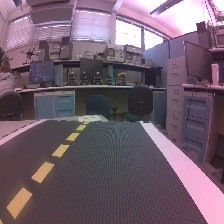

array([ 2.58785064e-02, -8.29507203e-01,  1.90080239e+02])

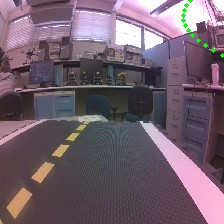

In [4]:
image = cv2.imread('Test_Lane_Images/image_0.jpg')
display(Image(data=bgr8_to_jpeg(image)))
poly, fitted_image = get_lane_curve_poly(image)
# deviation, valid = calculate_deviation(image, lines)
display(poly)
display(Image(data=bgr8_to_jpeg(fitted_image)))

In [5]:
def get_lane_curve_contour(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # White line detection (tweaked)
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([180, 50, 255])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    # Yellow line detection (tweaked)
    lower_yellow = np.array([18, 80, 80])
    upper_yellow = np.array([32, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    mask = cv2.bitwise_or(mask_white, mask_yellow)

    # Clean up noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if not contours:
        return None, image

    # Largest contour (lane)
    contour = max(contours, key=cv2.contourArea)
    pts = contour.squeeze()

    if pts.ndim != 2 or pts.shape[0] < 5:
        return None, image

    try:
        # Fit x = f(y)
        poly = np.polyfit(pts[:, 1], pts[:, 0], 2)

        # Draw fitted curve
        fitted_img = image.copy()
        for y in range(0, image.shape[0], 5):
            x = int(poly[0]*y**2 + poly[1]*y + poly[2])
            if 0 <= x < image.shape[1]:
                cv2.circle(fitted_img, (x, y), 2, (0, 255, 0), -1)
        return poly, fitted_img

    except Exception as e:
        print("Curve fitting failed:", e)
        return None, image


In [6]:
def compute_deviation_from_curve(poly, image_width, image_height):
    if poly is None:
        return 0.0, False

    y = image_height - 1
    x_lane = poly[0] * y**2 + poly[1] * y + poly[2]
    center = image_width / 2
    deviation = (x_lane - center) / center
    return deviation, True


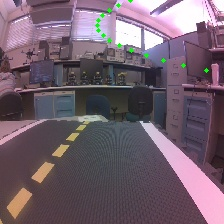

Deviation from center: 18.6440148541193


In [7]:
image = cv2.imread('Test_Lane_Images/image_0.jpg')  # Your uploaded file

poly, result_img = get_lane_curve_contour(image)

from IPython.display import Image, display
import cv2

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

display(Image(data=bgr8_to_jpeg(result_img)))

deviation, valid = compute_deviation_from_curve(poly, image.shape[1], image.shape[0])
print("Deviation from center:", deviation)


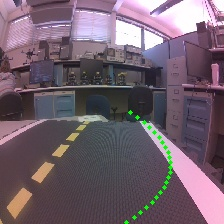

Deviation from center: 0.11601800207194987


In [8]:
import cv2
import numpy as np
from IPython.display import Image, display

# Utility: Convert image for Jupyter display
def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

# Detect and fit curved lane line from image
def get_lane_curve_contour(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Color masks for lane lines
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([180, 50, 255])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    lower_yellow = np.array([18, 80, 80])
    upper_yellow = np.array([32, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Choose only white or yellow depending on your use case
    mask = cv2.bitwise_or(mask_white, mask_yellow)

    # ROI: only bottom half of the image
    h, w = mask.shape
    roi = mask[h // 2:, :]
    roi_offset = h // 2

    # Clean up
    roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if not contours:
        return None, image

    # Largest contour
    contour = max(contours, key=cv2.contourArea)
    contour = contour.squeeze()
    if contour.ndim != 2 or contour.shape[0] < 5:
        return None, image

    # Shift back to full-image coordinates
    contour[:, 1] += roi_offset

    try:
        # Fit x = a*y^2 + b*y + c
        poly = np.polyfit(contour[:, 1], contour[:, 0], 2)

        # Draw fitted curve
        fitted_img = image.copy()
        for y in range(roi_offset, h, 5):
            x = int(poly[0]*y**2 + poly[1]*y + poly[2])
            if 0 <= x < w:
                cv2.circle(fitted_img, (x, y), 2, (0, 255, 0), -1)

        return poly, fitted_img

    except Exception as e:
        print("Curve fitting failed:", e)
        return None, image

# Compute deviation from lane center
def compute_deviation_from_curve(poly, image_width, image_height):
    if poly is None:
        return 0.0, False

    y = image_height - 1
    x_lane = poly[0] * y**2 + poly[1] * y + poly[2]
    center = image_width / 2
    deviation = (x_lane - center) / center
    return deviation, True

# Load test image
image = cv2.imread('Test_Lane_Images/image_0.jpg')

# Run detection and curve fitting
poly, result_img = get_lane_curve_contour(image)

# Display results
display(Image(data=bgr8_to_jpeg(result_img)))

# Deviation output
deviation, valid = compute_deviation_from_curve(poly, image.shape[1], image.shape[0])
print("Deviation from center:", deviation)


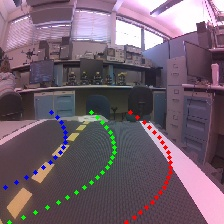

Deviation from lane center: -0.939973260491402


In [9]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

# Extract and fit each edge separately
def get_lane_edges_and_center(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, w = image.shape[:2]
    roi_y_start = h // 2

    # Color masks
    mask_white = cv2.inRange(hsv, (0, 0, 180), (180, 50, 255))
    mask_yellow = cv2.inRange(hsv, (18, 80, 80), (32, 255, 255))

    def extract_curve(mask, color):
        roi = mask[roi_y_start:, :]
        roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
        contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not contours:
            return None, None
        contour = max(contours, key=cv2.contourArea).squeeze()
        if contour.ndim != 2 or contour.shape[0] < 5:
            return None, None
        contour[:, 1] += roi_y_start
        try:
            poly = np.polyfit(contour[:, 1], contour[:, 0], 2)
            return poly, contour
        except:
            return None, None

    poly_left, left_pts = extract_curve(mask_yellow, (255, 0, 0))
    poly_right, right_pts = extract_curve(mask_white, (0, 0, 255))

    vis = image.copy()

    # Draw left and right curves
    for y in range(roi_y_start, h, 5):
        if poly_left is not None:
            x_l = int(poly_left[0]*y**2 + poly_left[1]*y + poly_left[2])
            if 0 <= x_l < w:
                cv2.circle(vis, (x_l, y), 2, (255, 0, 0), -1)  # Blue = left
        if poly_right is not None:
            x_r = int(poly_right[0]*y**2 + poly_right[1]*y + poly_right[2])
            if 0 <= x_r < w:
                cv2.circle(vis, (x_r, y), 2, (0, 0, 255), -1)  # Red = right

        # Draw center line between them
        if poly_left is not None and poly_right is not None:
            x_l = poly_left[0]*y**2 + poly_left[1]*y + poly_left[2]
            x_r = poly_right[0]*y**2 + poly_right[1]*y + poly_right[2]
            x_c = int((x_l + x_r) / 2)
            if 0 <= x_c < w:
                cv2.circle(vis, (x_c, y), 2, (0, 255, 0), -1)  # Green = center

    # Compute deviation from center
    if poly_left is not None and poly_right is not None:
        y = h - 1
        x_l = poly_left[0]*y**2 + poly_left[1]*y + poly_left[2]
        x_r = poly_right[0]*y**2 + poly_right[1]*y + poly_right[2]
        x_c = (x_l + x_r) / 2
        deviation = (x_c - w/2) / (w/2)
        return deviation, vis
    else:
        return 0.0, vis

# Load and process image
image = cv2.imread('Test_Lane_Images/image_0.jpg')
deviation, output_image = get_lane_edges_and_center(image)

# Show result
display(Image(data=bgr8_to_jpeg(output_image)))
print("Deviation from lane center:", deviation)


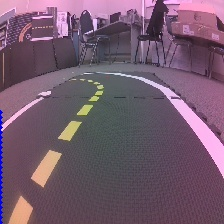

Deviation from lane center: 0.0


In [10]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def get_lane_edges_and_center(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, w = image.shape[:2]
    roi_y_start = h // 2

    # Color masks for lane lines
    mask_white = cv2.inRange(hsv, (0, 0, 180), (180, 50, 255))
    mask_yellow = cv2.inRange(hsv, (18, 80, 80), (32, 255, 255))

    def extract_line(mask, color, deg_max=2):
        roi = mask[roi_y_start:, :]
        roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
        contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not contours:
            return None, None
        contour = max(contours, key=cv2.contourArea).squeeze()
        if contour.ndim != 2 or contour.shape[0] < 5:
            return None, None
        contour[:, 1] += roi_y_start

        try:
            # Try quadratic fit
            poly2 = np.polyfit(contour[:, 1], contour[:, 0], 2)
            curve_strength = abs(poly2[0])  # a in ax^2 + bx + c

            if curve_strength < 1e-4:
                # Too straight, use linear instead
                poly = np.polyfit(contour[:, 1], contour[:, 0], 1)
                return poly, contour
            else:
                return poly2, contour
        except:
            return None, None


    # Use linear fit (deg=1) for straighter lanes
    poly_left, left_pts = extract_line(mask_yellow, (255, 0, 0), deg_max=1)
    poly_right, right_pts = extract_line(mask_white, (0, 0, 255), deg_max=1)

    vis = image.copy()

    # Draw fitted left and right lines
    for y in range(roi_y_start, h, 5):
        if poly_left is not None:
            x_l = int(poly_left[0]*y + poly_left[1])
            if 0 <= x_l < w:
                cv2.circle(vis, (x_l, y), 2, (255, 0, 0), -1)  # Blue

        if poly_right is not None:
            x_r = int(poly_right[0]*y + poly_right[1])
            if 0 <= x_r < w:
                cv2.circle(vis, (x_r, y), 2, (0, 0, 255), -1)  # Red

        # Center between them
        if poly_left is not None and poly_right is not None:
            x_l = poly_left[0]*y + poly_left[1]
            x_r = poly_right[0]*y + poly_right[1]
            x_c = int((x_l + x_r) / 2)
            if 0 <= x_c < w:
                cv2.circle(vis, (x_c, y), 2, (0, 255, 0), -1)  # Green

    # Compute deviation from center
    if poly_left is not None and poly_right is not None:
        y = h - 1
        x_l = poly_left[0]*y + poly_left[1]
        x_r = poly_right[0]*y + poly_right[1]
        x_c = (x_l + x_r) / 2
        deviation = (x_c - w/2) / (w/2)
        return deviation, vis
    else:
        return 0.0, vis

# Load and test with your consistent test image
image = cv2.imread('Test_Lane_Images/image_3.jpg')
deviation, output_image = get_lane_edges_and_center(image)

# Show results
display(Image(data=bgr8_to_jpeg(output_image)))
print("Deviation from lane center:", deviation)


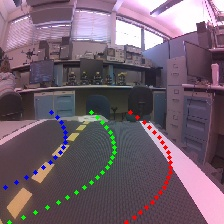

Deviation from lane center: -0.9399732604914014


In [11]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def get_lane_edges_and_center(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, w = image.shape[:2]
    roi_y_start = h // 2

    # Masks for yellow and white lines
    mask_white = cv2.inRange(hsv, (0, 0, 180), (180, 50, 255))
    mask_yellow = cv2.inRange(hsv, (18, 80, 80), (32, 255, 255))

    # === Inner function: adaptive curve/line fitting ===
    def extract_line(mask, color):
        roi = mask[roi_y_start:, :]
        roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
        contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not contours:
            return None, None
        contour = max(contours, key=cv2.contourArea).squeeze()
        if contour.ndim != 2 or contour.shape[0] < 5:
            return None, None
        contour[:, 1] += roi_y_start

        try:
            # Try quadratic fit first
            poly2 = np.polyfit(contour[:, 1], contour[:, 0], 2)
            curve_strength = abs(poly2[0])  # 'a' coefficient in ax^2 + bx + c

            if curve_strength < 1e-4:
                # Too straight, use linear fit
                poly = np.polyfit(contour[:, 1], contour[:, 0], 1)
                return poly, contour
            else:
                return poly2, contour
        except:
            return None, None

    # Apply to both left and right edges
    poly_left, left_pts = extract_line(mask_yellow, (255, 0, 0))
    poly_right, right_pts = extract_line(mask_white, (0, 0, 255))

    vis = image.copy()

    # Draw lines and center
    for y in range(roi_y_start, h, 5):
        x_l = x_r = None

        if poly_left is not None:
            x_l = np.polyval(poly_left, y)
            if 0 <= x_l < w:
                cv2.circle(vis, (int(x_l), y), 2, (255, 0, 0), -1)  # Blue

        if poly_right is not None:
            x_r = np.polyval(poly_right, y)
            if 0 <= x_r < w:
                cv2.circle(vis, (int(x_r), y), 2, (0, 0, 255), -1)  # Red

        # Centerline (if both edges exist)
        if x_l is not None and x_r is not None:
            x_c = int((x_l + x_r) / 2)
            cv2.circle(vis, (x_c, y), 2, (0, 255, 0), -1)  # Green

    # Compute deviation
    if poly_left is not None and poly_right is not None:
        y = h - 1
        x_l = np.polyval(poly_left, y)
        x_r = np.polyval(poly_right, y)
        x_c = (x_l + x_r) / 2
        deviation = (x_c - w/2) / (w/2)
        return deviation, vis
    else:
        return 0.0, vis

# === Run on your test image ===
image = cv2.imread('Test_Lane_Images/image_0.jpg')
deviation, output_image = get_lane_edges_and_center(image)

# Display result
display(Image(data=bgr8_to_jpeg(output_image)))
print("Deviation from lane center:", deviation)


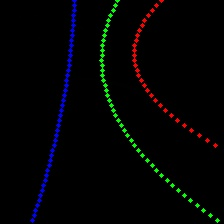

Deviation from center: 0.9856444195462792


In [12]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def sliding_window_lane_fit(image, nwindows=9, margin=25, minpix=20):
    h, w = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Binary lane mask
    mask_white = cv2.inRange(hsv, (0, 0, 180), (180, 50, 255))
    mask_yellow = cv2.inRange(hsv, (18, 80, 80), (32, 255, 255))
    binary = cv2.bitwise_or(mask_white, mask_yellow)

    # Histogram of bottom half
    histogram = np.sum(binary[h//2:, :], axis=0)

    # Find base of left and right peaks
    midpoint = w // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Sliding window setup
    window_height = h // nwindows
    nonzero = binary.nonzero()
    nonzeroy, nonzerox = np.array(nonzero[0]), np.array(nonzero[1])
    leftx_current, rightx_current = leftx_base, rightx_base
    left_lane_inds, right_lane_inds = [], []

    for window in range(nwindows):
        win_y_low = h - (window + 1) * window_height
        win_y_high = h - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit polynomials
    if len(leftx) < 5 or len(rightx) < 5:
        return image, 0.0

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Create image for visualization
    out_img = np.dstack((binary, binary, binary)) * 255

    for y in range(0, h, 5):
        x_l = int(left_fit[0]*y**2 + left_fit[1]*y + left_fit[2])
        x_r = int(right_fit[0]*y**2 + right_fit[1]*y + right_fit[2])
        x_c = int((x_l + x_r) / 2)
        if 0 <= x_l < w:
            cv2.circle(out_img, (x_l, y), 2, (255, 0, 0), -1)  # Blue
        if 0 <= x_r < w:
            cv2.circle(out_img, (x_r, y), 2, (0, 0, 255), -1)  # Red
        if 0 <= x_c < w:
            cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)  # Green

    # Deviation from center
    y_eval = h - 1
    x_l = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    x_r = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = (x_l + x_r) / 2
    image_center = w / 2
    deviation = (lane_center - image_center) / (w / 2)

    return out_img, deviation

# === Load and Run on Test Image ===
image = cv2.imread('Test_Lane_Images/image_4.jpg')
result, deviation = sliding_window_lane_fit(image)

# Show output
display(Image(data=bgr8_to_jpeg(result)))
print("Deviation from center:", deviation)


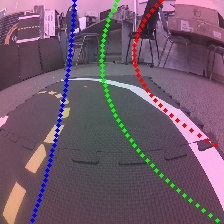

Deviation from lane center: 0.9856444195462792


In [13]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def sliding_window_lane_fit_on_original(image, nwindows=9, margin=25, minpix=20):
    h, w = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Binary lane mask
    mask_white = cv2.inRange(hsv, (0, 0, 180), (180, 50, 255))
    mask_yellow = cv2.inRange(hsv, (18, 80, 80), (32, 255, 255))
    binary = cv2.bitwise_or(mask_white, mask_yellow)

    # Histogram of bottom half
    histogram = np.sum(binary[h//2:, :], axis=0)
    midpoint = w // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Sliding window setup
    window_height = h // nwindows
    nonzero = binary.nonzero()
    nonzeroy, nonzerox = np.array(nonzero[0]), np.array(nonzero[1])
    leftx_current, rightx_current = leftx_base, rightx_base
    left_lane_inds, right_lane_inds = [], []

    for window in range(nwindows):
        win_y_low = h - (window + 1) * window_height
        win_y_high = h - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if len(leftx) < 5 or len(rightx) < 5:
        return image, 0.0

    # Fit 2nd degree polynomials
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Overlay results on the original image
    out_img = image.copy()

    for y in range(0, h, 5):
        x_l = int(left_fit[0]*y**2 + left_fit[1]*y + left_fit[2])
        x_r = int(right_fit[0]*y**2 + right_fit[1]*y + right_fit[2])
        x_c = int((x_l + x_r) / 2)

        if 0 <= x_l < w:
            cv2.circle(out_img, (x_l, y), 2, (255, 0, 0), -1)  # Blue
        if 0 <= x_r < w:
            cv2.circle(out_img, (x_r, y), 2, (0, 0, 255), -1)  # Red
        if 0 <= x_c < w:
            cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)  # Green

    # Compute deviation
    y_eval = h - 1
    x_l = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    x_r = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = (x_l + x_r) / 2
    image_center = w / 2
    deviation = (lane_center - image_center) / (w / 2)

    return out_img, deviation

# Load test image and apply sliding window fit
image = cv2.imread('Test_Lane_Images/image_4.jpg')
output_image, deviation = sliding_window_lane_fit_on_original(image)

# Display result
display(Image(data=bgr8_to_jpeg(output_image)))
print("Deviation from lane center:", deviation)


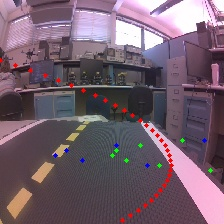

Deviation from lane center: 16.09232248919438


In [19]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def hybrid_lane_fit(image, nwindows=6, margin=25, minpix=20):
    h, w = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create binary mask
    mask_white = cv2.inRange(hsv, (0, 0, 180), (180, 50, 255))
    mask_yellow = cv2.inRange(hsv, (18, 80, 80), (32, 255, 255))
    binary = cv2.bitwise_or(mask_white, mask_yellow)

    # Bottom 1/3 histogram for initial base
    h_start = 2 * h // 3
    histogram = np.sum(binary[h_start:, :], axis=0)
    midpoint = w // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Sliding window setup
    window_height = (h - h_start) // nwindows
    nonzero = binary.nonzero()
    nonzeroy, nonzerox = np.array(nonzero[0]), np.array(nonzero[1])
    leftx_current, rightx_current = leftx_base, rightx_base
    left_lane_inds, right_lane_inds = [], []

    for window in range(nwindows):
        win_y_low = h - (window + 1) * window_height
        win_y_high = h - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Fit initial polynomials using lower region
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if len(leftx) < 5 or len(rightx) < 5:
        return image, 0.0

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # === Now search full image based on fit ===
    margin_search = 30
    left_inds = ((nonzerox > (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin_search)) &
                 (nonzerox < (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin_search)))

    right_inds = ((nonzerox > (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin_search)) &
                  (nonzerox < (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin_search)))

    # New full-lane fits
    leftx_full = nonzerox[left_inds]
    lefty_full = nonzeroy[left_inds]
    rightx_full = nonzerox[right_inds]
    righty_full = nonzeroy[right_inds]

    if len(leftx_full) < 5 or len(rightx_full) < 5:
        return image, 0.0

    left_fit = np.polyfit(lefty_full, leftx_full, 2)
    right_fit = np.polyfit(righty_full, rightx_full, 2)

    # === Visualization ===
    out_img = image.copy()
    for y in range(0, h, 5):
        x_l = int(left_fit[0]*y**2 + left_fit[1]*y + left_fit[2])
        x_r = int(right_fit[0]*y**2 + right_fit[1]*y + right_fit[2])
        x_c = int((x_l + x_r) / 2)
        if 0 <= x_l < w:
            cv2.circle(out_img, (x_l, y), 2, (255, 0, 0), -1)  # Blue
        if 0 <= x_r < w:
            cv2.circle(out_img, (x_r, y), 2, (0, 0, 255), -1)  # Red
        if 0 <= x_c < w:
            cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)  # Green

    # Deviation from center
    y_eval = h - 1
    x_l = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    x_r = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = (x_l + x_r) / 2
    image_center = w / 2
    deviation = (lane_center - image_center) / (w / 2)

    return out_img, deviation

# === Run on test image ===
image = cv2.imread('Test_Lane_Images/image_0.jpg')
result_img, deviation = hybrid_lane_fit(image)

# Display result
display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


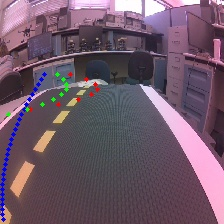

Deviation from lane center: -12.514401857410922


In [25]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def safe_polyfit(x, y, degree=2, min_pts=20):
    if len(x) >= min_pts and len(y) >= min_pts:
        return np.polyfit(y, x, degree)
    return None

def hybrid_lane_fit_fixed(image, nwindows=6, margin=30, minpix=20):
    h, w = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Focus only on bottom 2/3 of image
    roi = hsv[h//3:, :]
    offset = h // 3

    # Improved lane color detection
    mask_white = cv2.inRange(roi, (0, 0, 180), (180, 50, 255))
    mask_yellow = cv2.inRange(roi, (15, 100, 100), (35, 255, 255))
    binary = cv2.bitwise_or(mask_white, mask_yellow)

    histogram = np.sum(binary[binary.shape[0]//2:, :], axis=0)
    midpoint = w // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nonzero = binary.nonzero()
    nonzeroy = nonzero[0] + offset
    nonzerox = nonzero[1]

    window_height = (h - offset) // nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = h - (window + 1) * window_height
        win_y_high = h - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = safe_polyfit(leftx, lefty)
    right_fit = safe_polyfit(rightx, righty)

    # Visualization
    out_img = image.copy()
    for y in range(offset, h, 5):
        x_l = x_r = x_c = None
        if left_fit is not None:
            x_l = int(np.polyval(left_fit, y))
            if 0 <= x_l < w:
                cv2.circle(out_img, (x_l, y), 2, (255, 0, 0), -1)
        if right_fit is not None:
            x_r = int(np.polyval(right_fit, y))
            if 0 <= x_r < w:
                cv2.circle(out_img, (x_r, y), 2, (0, 0, 255), -1)
        if x_l is not None and x_r is not None:
            x_c = int((x_l + x_r) / 2)
            if 0 <= x_c < w:
                cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)

    # Deviation
    if left_fit is not None and right_fit is not None:
        y_eval = h - 1
        x_l = np.polyval(left_fit, y_eval)
        x_r = np.polyval(right_fit, y_eval)
        lane_center = (x_l + x_r) / 2
        image_center = w / 2
        deviation = (lane_center - image_center) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation

# === Run on test image ===
image = cv2.imread('Test_Lane_Images/image_1.jpg')
result_img, deviation = hybrid_lane_fit_fixed(image)

# Show result
display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


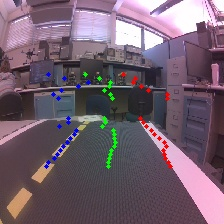

Deviation from lane center: -0.03571428571428571


In [36]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def get_lane_midline(image):
    h, w = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Contrast boost
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])

    # Threshold yellow and white
    mask_white = cv2.inRange(hsv, (0, 0, 170), (180, 40, 255))
    mask_yellow = cv2.inRange(hsv, (15, 80, 80), (35, 255, 255))
    mask = cv2.bitwise_or(mask_white, mask_yellow)

    # Stronger closing to thicken dashed lines
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)

    # Skeletonization
    skel = np.zeros_like(mask)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False
    img = mask.copy()
    while not done:
        eroded = cv2.erode(img, kernel)
        opened = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(img, opened)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        done = (cv2.countNonZero(img) == 0)

    # Contour extraction
    contours, _ = cv2.findContours(skel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) < 1:
        return image, 0.0

    mid_x = w // 2
    left_pts, right_pts = [], []

    for cnt in contours:
        for pt in cnt:
            x, y = pt[0]
            if y > h // 3:  # focus on bottom 2/3
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    out_img = image.copy()
    mid_pts = []

    # Generate midpoints
    for y in range(h // 3, h, 4):
        x_l = [x for (x, yy) in left_pts if abs(yy - y) <= 4]
        x_r = [x for (x, yy) in right_pts if abs(yy - y) <= 4]
        if x_l and x_r:
            x_left = int(np.mean(x_l))
            x_right = int(np.mean(x_r))
            x_center = (x_left + x_right) // 2
            cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)
            cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)
            cv2.circle(out_img, (x_center, y), 2, (0, 255, 0), -1)
            mid_pts.append((x_center, y))

    # Compute deviation
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w/2) / (w/2)
    else:
        deviation = 0.0

    return out_img, deviation


# === Run on test image ===
image = cv2.imread('Test_Lane_Images/image_0.jpg')
result_img, deviation = get_lane_midline(image)

# Show result
display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [37]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def get_lane_midline(image):
    h, w = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Histogram equalization for better contrast
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])

    # Threshold for white and yellow lanes
    mask_white = cv2.inRange(hsv, (0, 0, 170), (180, 40, 255))
    mask_yellow = cv2.inRange(hsv, (15, 80, 80), (35, 255, 255))
    mask = cv2.bitwise_or(mask_white, mask_yellow)

    # Strengthen lane mask using closing
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)

    # 💡 Horizon masking: remove top 45% of image
    horizon_line = int(h * 0.45)
    mask[:horizon_line, :] = 0

    # Skeletonization to get 1-pixel wide lines
    skel = np.zeros_like(mask)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False
    img = mask.copy()

    while not done:
        eroded = cv2.erode(img, kernel)
        opened = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(img, opened)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        done = (cv2.countNonZero(img) == 0)

    # Extract contours from skeleton
    contours, _ = cv2.findContours(skel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) < 1:
        return image, 0.0

    mid_x = w // 2
    left_pts, right_pts = [], []

    for cnt in contours:
        for pt in cnt:
            x, y = pt[0]
            if y > horizon_line:
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    out_img = image.copy()
    mid_pts = []

    # Midpoint extraction every few pixels
    for y in range(horizon_line, h, 4):
        x_l = [x for (x, yy) in left_pts if abs(yy - y) <= 4]
        x_r = [x for (x, yy) in right_pts if abs(yy - y) <= 4]
        if x_l and x_r:
            x_left = int(np.mean(x_l))
            x_right = int(np.mean(x_r))
            x_center = (x_left + x_right) // 2
            cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)   # Blue
            cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)  # Red
            cv2.circle(out_img, (x_center, y), 2, (0, 255, 0), -1) # Green
            mid_pts.append((x_center, y))

    # Compute deviation from image center
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w/2) / (w/2)
    else:
        deviation = 0.0

    return out_img, deviation


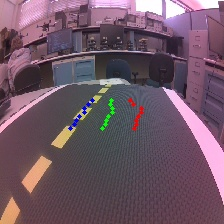

Deviation from lane center: -0.08928571428571429


In [43]:
image = cv2.imread('Test_Lane_Images/image_2.jpg')
result_img, deviation = get_lane_midline(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [44]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def get_lane_midline(image, debug_prefix='debug'):
    h, w = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # === 1. Contrast Boost ===
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])

    # === 2. Lane Color Mask ===
    mask_white = cv2.inRange(hsv, (0, 0, 170), (180, 40, 255))
    mask_yellow = cv2.inRange(hsv, (15, 80, 80), (35, 255, 255))
    mask = cv2.bitwise_or(mask_white, mask_yellow)

    # === 3. Morphological Closing ===
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)

    # === 4. Horizon Masking ===
    horizon_line = int(h * 0.45)
    mask[:horizon_line, :] = 0

    # Save binary mask for debug
    cv2.imwrite(f"{debug_prefix}_binary_mask.jpg", mask)

    # === 5. Skeletonization ===
    skel = np.zeros_like(mask)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    img = mask.copy()
    while True:
        eroded = cv2.erode(img, kernel)
        opened = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(img, opened)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break

    # Save skeleton image for debug
    cv2.imwrite(f"{debug_prefix}_skeleton.jpg", skel)

    # === 6. Find Contours in Skeleton ===
    contours, _ = cv2.findContours(skel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    mid_x = w // 2
    left_pts, right_pts = [], []

    for cnt in contours:
        for pt in cnt:
            x, y = pt[0]
            if y > horizon_line:
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    # === 7. Visualization and Midpoint Extraction ===
    out_img = image.copy()
    mid_pts = []

    # Draw raw edge points for debug (optional)
    for x, y in left_pts:
        cv2.circle(out_img, (x, y), 1, (255, 128, 0), -1)  # Orange: raw left
    for x, y in right_pts:
        cv2.circle(out_img, (x, y), 1, (0, 128, 255), -1)  # Teal: raw right

    for y in range(horizon_line, h, 4):
        x_l = [x for (x, yy) in left_pts if abs(yy - y) <= 4]
        x_r = [x for (x, yy) in right_pts if abs(yy - y) <= 4]
        if x_l and x_r:
            x_left = int(np.mean(x_l))
            x_right = int(np.mean(x_r))
            x_center = (x_left + x_right) // 2
            cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)   # Blue
            cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)  # Red
            cv2.circle(out_img, (x_center, y), 2, (0, 255, 0), -1) # Green
            mid_pts.append((x_center, y))

    # Save final annotated image with lane points
    cv2.imwrite(f"{debug_prefix}_lane_points.jpg", out_img)

    # === 8. Deviation Calculation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


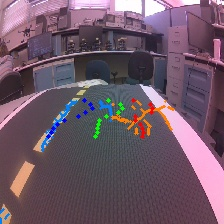

Deviation from lane center: -0.15178571428571427


In [47]:
image = cv2.imread('Test_Lane_Images/image_1.jpg')
result_img, deviation = get_lane_midline(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [48]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def get_lane_midline_clean(image, debug_prefix='debug'):
    h, w = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # === 1. Histogram Equalization (brightness balance) ===
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])

    # === 2. Improved Color Masking ===
    mask_white = cv2.inRange(hsv, (0, 0, 200), (180, 40, 255))
    mask_yellow = cv2.inRange(hsv, (20, 100, 100), (35, 255, 255))
    mask = cv2.bitwise_or(mask_white, mask_yellow)

    # === 3. Morphological Cleanup ===
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)

    # === 4. Horizon Mask ===
    horizon_line = int(h * 0.45)
    mask[:horizon_line, :] = 0

    # === 5. Find Contours Directly (no skeleton) ===
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    mid_x = w // 2
    left_pts, right_pts = [], []

    for cnt in contours:
        for pt in cnt:
            x, y = pt[0]
            if y > horizon_line:
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    out_img = image.copy()
    mid_pts = []

    for y in range(horizon_line, h, 4):
        x_l = [x for (x, yy) in left_pts if abs(yy - y) <= 4]
        x_r = [x for (x, yy) in right_pts if abs(yy - y) <= 4]

        if x_l and x_r:
            x_left = int(np.mean(x_l))
            x_right = int(np.mean(x_r))
            x_center = (x_left + x_right) // 2

            cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)   # Blue
            cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)  # Red
            cv2.circle(out_img, (x_center, y), 2, (0, 255, 0), -1) # Green
            mid_pts.append((x_center, y))

    # === 6. Deviation from image center ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


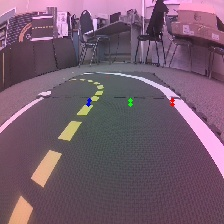

Deviation from lane center: 0.16071428571428573


In [54]:
image = cv2.imread('Test_Lane_Images/image_3.jpg')
result_img, deviation = get_lane_midline_clean(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [58]:
import CP_constants as const
def detect_lane_markings(image: np.ndarray):
    """
    Args:
        image: An image from the robot's camera in the BGR color space (numpy.ndarray)
    Return:
        left_masked_img:   Masked image for the dashed-yellow line (numpy.ndarray)
        right_masked_img:  Masked image for the solid-white line (numpy.ndarray)
    """
    h, w, _ = image.shape
    # print(image.shape)
    # h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(np.array(const.mtx), np.array(const.dist), (w,h), 1, (w,h))

    # undistort
    dst = cv2.undistort(image, np.array(const.mtx), np.array(const.dist), None, newcameramtx)
    # display(Image(data=bgr8_to_jpeg(dst)))

    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    # display(Image(data=bgr8_to_jpeg(dst)))

    imgbgr = dst

    # Convert the image to HSV for any color-based filtering
    imghsv = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HSV)

    # Most of our operations will be performed on the grayscale version
    imggray = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2GRAY)

    horizon_X = 40
    mask_ground = np.zeros((h, w), dtype=np.uint8)
    mask_ground[int(h - horizon_X) :, :] = 1
    # print(h," " ,w," " ,int(h - horizon_X[0]))

    sigma = 8  # CHANGE ME

    # Smooth the image using a Gaussian kernel
    img_gaussian_filter = cv2.GaussianBlur(imggray, (0, 0), sigma)

    # Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
    sobelx = cv2.Sobel(img_gaussian_filter, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img_gaussian_filter, cv2.CV_64F, 0, 1)

    # Compute the magnitude of the gradients
    Gmag = np.sqrt(sobelx * sobelx + sobely * sobely)

    threshold_left = 5  # CHANGE ME
    mask_mag_left = Gmag > threshold_left
    threshold_right = 5
    mask_mag_right = Gmag > threshold_right

    white_lower_hsv = np.array([15, 3, 166])  # CHANGE ME
    white_upper_hsv = np.array([179, 116, 255])  # CHANGE ME
    yellow_lower_hsv = np.array([10, 75, 50])        # CHANGE ME
    yellow_upper_hsv = np.array([35, 255, 255])  # CHANGE ME

    mask_white = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
    mask_yellow = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

    mask_left = np.ones(sobelx.shape)
    mask_left[:, int(np.floor(w / 2)) : w + 1] = 0
    mask_right = np.ones(sobelx.shape)
    mask_right[:, 0 : int(np.floor(w / 2))] = 0

    mask_sobelx_pos = sobelx > 0
    mask_sobelx_neg = sobelx < 0
    mask_sobely_neg = sobely < 0

    mask_left_edge = mask_ground * mask_left * mask_mag_left * mask_sobelx_neg * mask_sobely_neg * mask_yellow
    mask_right_edge = mask_ground * mask_right * mask_mag_right * mask_sobelx_pos * mask_sobely_neg * mask_white
    mask_lanes = np.uint8((mask_left_edge + mask_right_edge) > 0) * 255
    test_image = imggray*mask_ground*mask_right
    masked_image = cv2.bitwise_and(imggray, imggray, mask=mask_lanes)
    display(Image(data=bgr8_to_jpeg(test_image)))
    # display(Image(data=bgr8_to_jpeg(image)))
    ret, masked_image = cv2.threshold(                                   # soebel img to binary by threshold
        masked_image, 7, 255, cv2.THRESH_BINARY)
    return masked_image

In [59]:
def analyze_lane_from_masked_image(image, masked_image):
    """
    Args:
        image: Original undistorted grayscale or BGR image
        masked_image: Binary lane mask (from detect_lane_markings)
    Returns:
        output image with overlay + normalized deviation from center
    """
    h, w = masked_image.shape[:2]
    out_img = image.copy() if len(image.shape) == 3 else cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Find contours on binary lane mask
    contours, _ = cv2.findContours(masked_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    mid_x = w // 2
    left_pts, right_pts = [], []

    for cnt in contours:
        for pt in cnt:
            x, y = pt[0]
            if y > int(h * 0.45):  # below horizon
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    mid_pts = []

    for y in range(int(h * 0.45), h, 4):
        x_l = [x for (x, yy) in left_pts if abs(yy - y) <= 4]
        x_r = [x for (x, yy) in right_pts if abs(yy - y) <= 4]
        if x_l and x_r:
            x_left = int(np.mean(x_l))
            x_right = int(np.mean(x_r))
            x_center = (x_left + x_right) // 2
            cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)   # Blue
            cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)  # Red
            cv2.circle(out_img, (x_center, y), 2, (0, 255, 0), -1) # Green
            mid_pts.append((x_center, y))

    # Deviation
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


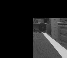

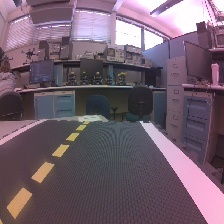

Deviation from lane center: 0.0


In [60]:
original = cv2.imread('Test_Lane_Images/image_0.jpg')
masked = detect_lane_markings(original)
result_img, deviation = analyze_lane_from_masked_image(original, masked)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [61]:
import cv2
import numpy as np
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def get_lane_midline_refined(image, debug_prefix='debug'):
    h, w = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Histogram equalization for contrast
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])

    # Wider HSV thresholds for robustness
    mask_white = cv2.inRange(hsv, (0, 0, 160), (180, 60, 255))
    mask_yellow = cv2.inRange(hsv, (15, 60, 60), (40, 255, 255))
    mask = cv2.bitwise_or(mask_white, mask_yellow)

    # Morphological closing
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)

    # Horizon masking
    horizon_line = int(h * 0.45)
    mask[:horizon_line, :] = 0

    # Contour detection
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    mid_x = w // 2
    left_pts, right_pts = [], []

    for cnt in contours:
        if cv2.contourArea(cnt) < 20:  # ignore small noise blobs
            continue
        for pt in cnt:
            x, y = pt[0]
            if y > horizon_line:
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    # Optional: filter outliers using y-banded clustering
    def smooth_edge(pts):
        cleaned = []
        for y in range(horizon_line, h, 4):
            x_band = [x for (x, yy) in pts if abs(yy - y) <= 4]
            if x_band:
                x_avg = int(np.mean(x_band))
                cleaned.append((x_avg, y))
        return cleaned

    left_clean = smooth_edge(left_pts)
    right_clean = smooth_edge(right_pts)

    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []

    for (y_i, y) in enumerate(range(horizon_line, h, 4)):
        if y_i >= len(left_clean) or y_i >= len(right_clean):
            continue
        x_left, _ = left_clean[y_i]
        x_right, _ = right_clean[y_i]
        x_center = (x_left + x_right) // 2

        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)   # Blue
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)  # Red
        cv2.circle(out_img, (x_center, y), 2, (0, 255, 0), -1) # Green
        mid_pts.append((x_center, y))

    # Deviation
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


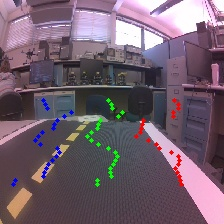

Deviation from lane center: -0.13392857142857142


In [67]:
image = cv2.imread('Test_Lane_Images/image_0.jpg')
result_img, deviation = get_lane_midline_refined(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [68]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def get_lane_midline_debug(image, debug_prefix='debug'):
    h, w = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])  # Brightness normalization

    # === 1. HSV Thresholds (relaxed for robustness) ===
    mask_white = cv2.inRange(hsv, (0, 0, 160), (180, 60, 255))
    mask_yellow = cv2.inRange(hsv, (15, 60, 60), (40, 255, 255))
    mask = cv2.bitwise_or(mask_white, mask_yellow)

    # === 2. Morphological closing ===
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)

    # === 3. Horizon masking ===
    horizon_line = int(h * 0.45)
    mask[:horizon_line, :] = 0

    # === 4. Save debug masks ===
    cv2.imwrite(f"{debug_prefix}_mask.jpg", mask)
    cv2.imwrite(f"{debug_prefix}_white.jpg", mask_white)
    cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)

    # === 5. Contour detection ===
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    mid_x = w // 2
    left_pts, right_pts = [], []

    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            if y > horizon_line:
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    # === 6. Bandwise smoothing (y axis) ===
    def smooth_edge(pts):
        bands = []
        for y in range(horizon_line, h, 4):
            x_band = [x for (x, yy) in pts if abs(yy - y) <= 4]
            if x_band:
                x_avg = int(np.mean(x_band))
                bands.append((x_avg, y))
        return bands

    left_clean = smooth_edge(left_pts)
    right_clean = smooth_edge(right_pts)

    # === 7. Midline calculation and optional smoothing ===
    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    for i in range(min(len(left_clean), len(right_clean))):
        x_left, y = left_clean[i]
        x_right, _ = right_clean[i]
        x_center = (x_left + x_right) // 2
        mid_pts.append((x_center, y))
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)   # Blue
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)  # Red

    # === 8. Apply median filter to centerline ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for x, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), y), 2, (0, 255, 0), -1)  # Green midline

    # === 9. Save overlay image ===
    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 10. Deviation calculation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


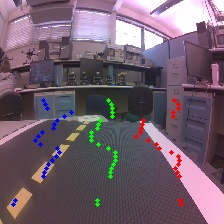

Deviation from lane center: -0.13392857142857142


In [71]:
image = cv2.imread('Test_Lane_Images/image_0.jpg')
result_img, deviation = get_lane_midline_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [72]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def get_lane_midline_debug(image, debug_prefix='debug'):
    h, w = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])  # Enhance brightness contrast

    # === 1. Updated HSV Thresholds ===
    # White: ignore bright wall areas
    mask_white = cv2.inRange(hsv, (0, 0, 200), (180, 40, 245))

    # Yellow: pick up faded dashed lines
    mask_yellow = cv2.inRange(hsv, (18, 70, 40), (40, 255, 255))

    # Combine masks
    mask = cv2.bitwise_or(mask_white, mask_yellow)

    # === 2. Morphological Closing ===
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)

    # === 3. Horizon Mask ===
    horizon_line = int(h * 0.45)
    mask[:horizon_line, :] = 0

    # === 4. Save Debug Masks ===
    cv2.imwrite(f"{debug_prefix}_mask.jpg", mask)
    cv2.imwrite(f"{debug_prefix}_white.jpg", mask_white)
    cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)

    # === 5. Contour Detection ===
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    mid_x = w // 2
    left_pts, right_pts = [], []

    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            if y > horizon_line:
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    # === 6. Band-wise Smoothing ===
    def smooth_edge(pts):
        bands = []
        for y in range(horizon_line, h, 4):
            x_band = [x for (x, yy) in pts if abs(yy - y) <= 4]
            if x_band:
                x_avg = int(np.mean(x_band))
                bands.append((x_avg, y))
        return bands

    left_clean = smooth_edge(left_pts)
    right_clean = smooth_edge(right_pts)

    # === 7. Midline Calculation (with Lane Width Filtering) ===
    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_lane_width = w * 0.75

    for i in range(min(len(left_clean), len(right_clean))):
        x_left, y = left_clean[i]
        x_right, _ = right_clean[i]

        if abs(x_right - x_left) > max_lane_width:
            continue  # skip bad pairs

        x_center = (x_left + x_right) // 2
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)   # Blue
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)  # Red
        mid_pts.append((x_center, y))

    # === 8. Midline Smoothing (Median Filter) ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for x, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), y), 2, (0, 255, 0), -1)  # Green midline

    # === 9. Save Final Overlay ===
    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 10. Deviation Calculation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


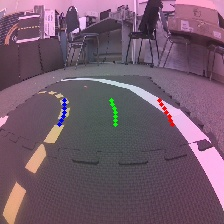

Deviation from lane center: 0.026785714285714284


In [78]:
image = cv2.imread('Test_Lane_Images/image_4.jpg')
result_img, deviation = get_lane_midline_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [79]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    """Brighten dark areas using gamma correction."""
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]

    # === 1. Gamma correction ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. HSV processing ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])

    # === 3. Tuned HSV thresholds ===
    mask_white = cv2.inRange(hsv, (0, 0, 200), (180, 40, 245))
    mask_yellow = cv2.inRange(hsv, (18, 70, 40), (40, 255, 255))
    mask = cv2.bitwise_or(mask_white, mask_yellow)

    # === 4. Morphological closing ===
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)

    # === 5. Horizon masking ===
    horizon_line = int(h * 0.45)
    mask[:horizon_line, :] = 0

    # === 6. Save debug images ===
    cv2.imwrite(f"{debug_prefix}_mask.jpg", mask)
    cv2.imwrite(f"{debug_prefix}_white.jpg", mask_white)
    cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)

    # === 7. Contour extraction ===
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    mid_x = w // 2
    left_pts, right_pts = [], []

    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            if y > horizon_line:
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    # === 8. Band-wise averaging ===
    def smooth_edge(pts):
        bands = []
        for y in range(horizon_line, h, 4):
            x_band = [x for (x, yy) in pts if abs(yy - y) <= 4]
            if x_band:
                x_avg = int(np.mean(x_band))
                bands.append((x_avg, y))
        return bands

    left_clean = smooth_edge(left_pts)
    right_clean = smooth_edge(right_pts)

    # === 9. Midline computation with lane width filtering ===
    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_lane_width = w * 0.75

    for i in range(min(len(left_clean), len(right_clean))):
        x_left, y = left_clean[i]
        x_right, _ = right_clean[i]

        if abs(x_right - x_left) > max_lane_width:
            continue

        x_center = (x_left + x_right) // 2
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)   # Blue
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)  # Red
        mid_pts.append((x_center, y))

    # === 10. Midline smoothing ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), y), 2, (0, 255, 0), -1)  # Green

    # === 11. Save overlay ===
    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 12. Deviation from center ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


C:\Users\B-Dog\AppData\Local\Temp\ipykernel_27100\3526067947.py:95: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  x_smooth = medfilt(x_vals, kernel_size=5)


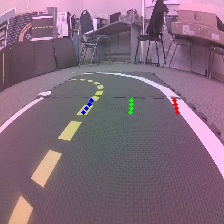

Deviation from lane center: 0.16071428571428573


In [89]:
image = cv2.imread('Test_Lane_Images/image_3.jpg')
result_img, deviation = get_lane_midline_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [90]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_hsv_sobel_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])

    # === 1. HSV Thresholds ===
    mask_white = cv2.inRange(hsv, (0, 0, 200), (180, 40, 245))
    mask_yellow = cv2.inRange(hsv, (18, 70, 40), (40, 255, 255))
    mask_hsv = cv2.bitwise_or(mask_white, mask_yellow)
    mask_hsv = cv2.morphologyEx(mask_hsv, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)

    # === 2. Sobel X on Grayscale ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    # Limit Sobel to bottom portion
    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]

    # === 3. Combine HSV + Sobel logic ===
    # Left = yellow + Sobel (left half), Right = white + Sobel (right half)
    mid_x = w // 2
    left_mask = np.zeros_like(mask_hsv)
    right_mask = np.zeros_like(mask_hsv)
    left_mask[:, :mid_x] = 1
    right_mask[:, mid_x:] = 1

    mask_yellow_sobel = cv2.bitwise_and(mask_yellow, sobel_mask)
    mask_white_sobel = cv2.bitwise_and(mask_white, sobel_mask)

    left_combined = cv2.bitwise_and(mask_yellow_sobel, mask_yellow_sobel, mask=left_mask)
    right_combined = cv2.bitwise_and(mask_white_sobel, mask_white_sobel, mask=right_mask)

    final_mask = cv2.bitwise_or(left_combined, right_combined)

    # === 4. Save Debug Images ===
    cv2.imwrite(f"{debug_prefix}_hsv_mask.jpg", mask_hsv)
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_mask)
    cv2.imwrite(f"{debug_prefix}_left_combined.jpg", left_combined)
    cv2.imwrite(f"{debug_prefix}_right_combined.jpg", right_combined)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", final_mask)

    # === 5. Find Contours ===
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    left_pts, right_pts = [], []

    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            if y > int(h * 0.45):
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    # === 6. Band-Wise Filtering ===
    def smooth_edge(pts):
        bands = []
        for y in range(int(h * 0.45), h, 4):
            x_band = [x for (x, yy) in pts if abs(yy - y) <= 4]
            if x_band:
                x_avg = int(np.mean(x_band))
                bands.append((x_avg, y))
        return bands

    left_clean = smooth_edge(left_pts)
    right_clean = smooth_edge(right_pts)

    # === 7. Midline and Deviation ===
    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_lane_width = w * 0.75

    for i in range(min(len(left_clean), len(right_clean))):
        x_left, y = left_clean[i]
        x_right, _ = right_clean[i]
        if abs(x_right - x_left) > max_lane_width:
            continue
        x_center = (x_left + x_right) // 2
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)   # Blue
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)  # Red
        mid_pts.append((x_center, y))

    # Midline smoothing
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), y), 2, (0, 255, 0), -1)  # Green midline

    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # Final deviation
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


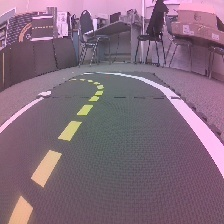

Deviation from lane center: 0.0


In [96]:
image = cv2.imread('Test_Lane_Images/image_3.jpg')
result_img, deviation = get_lane_midline_hsv_sobel_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [97]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_hybrid_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])

    # === 1. HSV Mask for Yellow Only ===
    mask_yellow = cv2.inRange(hsv, (18, 70, 40), (40, 255, 255))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)

    # === 2. Sobel X Gradient ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    # Only keep bottom portion
    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]

    # === 3. Combine Masks ===
    mid_x = w // 2
    left_mask = np.zeros_like(mask_yellow)
    right_mask = np.zeros_like(mask_yellow)
    left_mask[:, :mid_x] = 1
    right_mask[:, mid_x:] = 1

    # Left: yellow ∩ sobel ∩ left_half
    mask_yellow_sobel = cv2.bitwise_and(mask_yellow, sobel_mask)
    left_combined = cv2.bitwise_and(mask_yellow_sobel, mask_yellow_sobel, mask=left_mask)

    # Right: sobel only ∩ right_half
    right_combined = cv2.bitwise_and(sobel_mask, sobel_mask, mask=right_mask)

    final_mask = cv2.bitwise_or(left_combined, right_combined)

    # === 4. Save Debug Images ===
    cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_mask)
    cv2.imwrite(f"{debug_prefix}_left_combined.jpg", left_combined)
    cv2.imwrite(f"{debug_prefix}_right_combined.jpg", right_combined)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", final_mask)

    # === 5. Contour-Based Point Extraction ===
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    left_pts, right_pts = [], []

    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            if y > int(h * 0.45):
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    def smooth_edge(pts):
        bands = []
        for y in range(int(h * 0.45), h, 4):
            x_band = [x for (x, yy) in pts if abs(yy - y) <= 4]
            if x_band:
                x_avg = int(np.mean(x_band))
                bands.append((x_avg, y))
        return bands

    left_clean = smooth_edge(left_pts)
    right_clean = smooth_edge(right_pts)

    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_lane_width = w * 0.75

    for i in range(min(len(left_clean), len(right_clean))):
        x_left, y = left_clean[i]
        x_right, _ = right_clean[i]
        if abs(x_right - x_left) > max_lane_width:
            continue
        x_center = (x_left + x_right) // 2
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)
        mid_pts.append((x_center, y))

    # Median smoothing for midline
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), y), 2, (0, 255, 0), -1)

    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


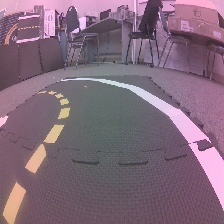

Deviation from lane center: 0.0


In [102]:
image = cv2.imread('Test_Lane_Images/image_4.jpg')
result_img, deviation = get_lane_midline_hybrid_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [103]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_sobel_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]

    # === 1. Gamma Correction ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. Grayscale + Sobel X ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    # Only bottom portion
    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]

    # === 3. Morphological Closing to Strengthen Edges ===
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === 4. Split into Left and Right Masks ===
    mid_x = w // 2
    left_mask = np.zeros_like(sobel_mask)
    right_mask = np.zeros_like(sobel_mask)
    left_mask[:, :mid_x] = 1
    right_mask[:, mid_x:] = 1

    left_combined = cv2.bitwise_and(sobel_mask, sobel_mask, mask=left_mask)
    right_combined = cv2.bitwise_and(sobel_mask, sobel_mask, mask=right_mask)
    final_mask = cv2.bitwise_or(left_combined, right_combined)

    # === 5. Save Debug Outputs ===
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
    cv2.imwrite(f"{debug_prefix}_left_combined.jpg", left_combined)
    cv2.imwrite(f"{debug_prefix}_right_combined.jpg", right_combined)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", final_mask)

    # === 6. Extract Points from Contours ===
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    left_pts, right_pts = [], []

    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            if y > int(h * 0.45):
                if x < mid_x:
                    left_pts.append((x, y))
                else:
                    right_pts.append((x, y))

    def smooth_edge(pts):
        bands = []
        for y in range(int(h * 0.45), h, 4):
            x_band = [x for (x, yy) in pts if abs(yy - y) <= 4]
            if x_band:
                x_avg = int(np.mean(x_band))
                bands.append((x_avg, y))
        return bands

    left_clean = smooth_edge(left_pts)
    right_clean = smooth_edge(right_pts)

    # === 7. Compute Midline ===
    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_lane_width = w * 0.75

    for i in range(min(len(left_clean), len(right_clean))):
        x_left, y = left_clean[i]
        x_right, _ = right_clean[i]
        if abs(x_right - x_left) > max_lane_width:
            continue
        x_center = (x_left + x_right) // 2
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)   # Blue
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)  # Red
        mid_pts.append((x_center, y))

    # === 8. Midline Smoothing ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), y), 2, (0, 255, 0), -1)  # Green midline

    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 9. Deviation from center ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


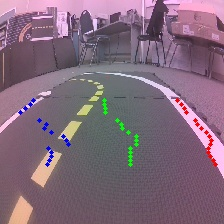

Deviation from lane center: 0.16071428571428573


In [110]:
image = cv2.imread('Test_Lane_Images/image_3.jpg')
result_img, deviation = get_lane_midline_sobel_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [111]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_sobel_roi_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    
    # === 1. Contrast boost ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. Sobel X Edge Detection ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === 3. Define ROI bounds for left/right lanes ===
    left_x_min, left_x_max = int(w * 0.05), int(w * 0.45)
    right_x_min, right_x_max = int(w * 0.55), int(w * 0.95)

    left_mask = np.zeros_like(sobel_mask)
    right_mask = np.zeros_like(sobel_mask)
    left_mask[:, left_x_min:left_x_max] = 1
    right_mask[:, right_x_min:right_x_max] = 1

    left_combined = cv2.bitwise_and(sobel_mask, sobel_mask, mask=left_mask)
    right_combined = cv2.bitwise_and(sobel_mask, sobel_mask, mask=right_mask)
    final_mask = cv2.bitwise_or(left_combined, right_combined)

    # === 4. Save debug images ===
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
    cv2.imwrite(f"{debug_prefix}_left_combined.jpg", left_combined)
    cv2.imwrite(f"{debug_prefix}_right_combined.jpg", right_combined)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", final_mask)

    # === 5. Extract edge points ===
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    left_pts, right_pts = [], []

    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            if y > int(h * 0.45):
                if left_x_min <= x <= left_x_max:
                    left_pts.append((x, y))
                elif right_x_min <= x <= right_x_max:
                    right_pts.append((x, y))

    def smooth_edge(pts):
        bands = []
        for y in range(int(h * 0.45), h, 4):
            x_band = [x for (x, yy) in pts if abs(yy - y) <= 4]
            if x_band:
                x_avg = int(np.mean(x_band))
                bands.append((x_avg, y))
        return bands

    left_clean = smooth_edge(left_pts)
    right_clean = smooth_edge(right_pts)

    # === 6. Midline & overlay ===
    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_lane_width = w * 0.75

    for i in range(min(len(left_clean), len(right_clean))):
        x_left, y = left_clean[i]
        x_right, _ = right_clean[i]
        if abs(x_right - x_left) > max_lane_width:
            continue
        x_center = (x_left + x_right) // 2
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)
        mid_pts.append((x_center, y))

    # Smooth midline
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), y), 2, (0, 255, 0), -1)

    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 7. Compute deviation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


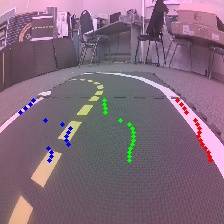

Deviation from lane center: 0.15178571428571427


In [118]:
image = cv2.imread('Test_Lane_Images/image_3.jpg')
result_img, deviation = get_lane_midline_sobel_roi_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [119]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_adaptive_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]

    # === 1. Gamma correction ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. HSV + Sobel X preprocessing ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])

    # Broad HSV thresholds
    mask_white = cv2.inRange(hsv, (0, 0, 160), (180, 80, 255))
    mask_yellow = cv2.inRange(hsv, (15, 50, 50), (40, 255, 255))
    mask_hsv = cv2.bitwise_or(mask_white, mask_yellow)

    # Sobel X
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]

    # Combine HSV and Sobel (union)
    mask_combined = cv2.bitwise_or(mask_hsv, sobel_mask)
    mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === 3. Save Debug Images ===
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
    cv2.imwrite(f"{debug_prefix}_hsv_mask.jpg", mask_hsv)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", mask_combined)

    # === 4. Extract all edge points ===
    contours, _ = cv2.findContours(mask_combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    edge_pts = []

    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            if y > int(h * 0.45):
                edge_pts.append((x, y))

    # === 5. Dynamic midline pairing by closeness to center ===
    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_x = w // 2
    mid_pts = []
    for y in range(int(h * 0.45), h, 4):
        row_pts = [x for (x, yy) in edge_pts if abs(yy - y) <= 2]
        if len(row_pts) < 2:
            continue
        row_pts_sorted = sorted(row_pts, key=lambda x: abs(x - mid_x))
        left = [x for x in row_pts_sorted if x < mid_x]
        right = [x for x in row_pts_sorted if x > mid_x]
        if not left or not right:
            continue
        x_left = left[0]
        x_right = right[0]
        x_center = (x_left + x_right) // 2

        # Draw overlay
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)
        mid_pts.append((x_center, y))

    # === 6. Midline smoothing ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)

    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 7. Deviation from image center ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


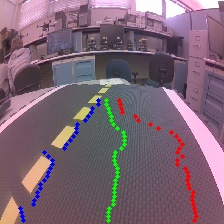

Deviation from lane center: -0.03571428571428571


In [131]:
image = cv2.imread('Test_Lane_Images/image_2.jpg')
result_img, deviation = get_lane_midline_adaptive_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [132]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_adaptive_outlier_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]

    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])

    # Broad HSV thresholds
    mask_white = cv2.inRange(hsv, (0, 0, 160), (180, 80, 255))
    mask_yellow = cv2.inRange(hsv, (15, 50, 50), (40, 255, 255))
    mask_hsv = cv2.bitwise_or(mask_white, mask_yellow)

    # Sobel X
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    # Apply Sobel only to bottom half
    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]

    # Combine HSV and Sobel
    mask_combined = cv2.bitwise_or(mask_hsv, sobel_mask)
    mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # Save debug images
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
    cv2.imwrite(f"{debug_prefix}_hsv_mask.jpg", mask_hsv)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", mask_combined)

    # Extract all contour points
    contours, _ = cv2.findContours(mask_combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    edge_pts = []

    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            if y > int(h * 0.45):
                edge_pts.append((x, y))

    # Build dynamic midline with outlier rejection
    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_x = w // 2
    mid_pts = []
    max_deviation_from_mid = int(w * 0.4)  # prevent far-side pairings

    for y in range(int(h * 0.45), h, 4):
        row_pts = [x for (x, yy) in edge_pts if abs(yy - y) <= 2]
        if len(row_pts) < 2:
            continue
        row_pts_sorted = sorted(row_pts, key=lambda x: abs(x - mid_x))

        # Find closest left and right that are not too far from center
        x_left = next((x for x in row_pts_sorted if x < mid_x and abs(x - mid_x) <= max_deviation_from_mid), None)
        x_right = next((x for x in row_pts_sorted if x > mid_x and abs(x - mid_x) <= max_deviation_from_mid), None)

        if x_left is None or x_right is None:
            continue

        x_center = (x_left + x_right) // 2
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)
        mid_pts.append((x_center, y))

    # Midline smoothing
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)

    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


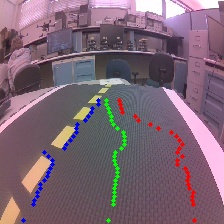

Deviation from lane center: -0.03571428571428571


In [138]:
image = cv2.imread('Test_Lane_Images/image_2.jpg')
result_img, deviation = get_lane_midline_adaptive_outlier_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [139]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_adaptive_stable_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    # === 1. Gamma Correction ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. HSV + Sobel ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])

    mask_white = cv2.inRange(hsv, (0, 0, 160), (180, 80, 255))
    mask_yellow = cv2.inRange(hsv, (15, 50, 50), (40, 255, 255))
    mask_hsv = cv2.bitwise_or(mask_white, mask_yellow)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]

    # === 3. Combine Masks ===
    mask_combined = cv2.bitwise_or(mask_hsv, sobel_mask)
    mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === 4. Save Debug Images ===
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
    cv2.imwrite(f"{debug_prefix}_hsv_mask.jpg", mask_hsv)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", mask_combined)

    # === 5. Extract edge points from contours ===
    contours, _ = cv2.findContours(mask_combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    edge_pts = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            if y > int(h * 0.45):
                edge_pts.append((x, y))

    # === 6. Compute midline with slope filtering ===
    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_dev = int(w * 0.4)
    max_slope_deg = 30  # maximum allowable change in angle

    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        row_pts = [x for (x, yy) in edge_pts if abs(yy - y) <= 2]
        if len(row_pts) < 2:
            continue
        row_pts_sorted = sorted(row_pts, key=lambda x: abs(x - mid_x))
        x_left = next((x for x in row_pts_sorted if x < mid_x and abs(x - mid_x) <= max_dev), None)
        x_right = next((x for x in row_pts_sorted if x > mid_x and abs(x - mid_x) <= max_dev), None)

        if x_left is None or x_right is None:
            continue

        x_center = (x_left + x_right) // 2

        # Slope filtering
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        # Draw overlay
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)

    # === 7. Smooth and draw midline ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)

    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 8. Compute deviation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - w / 2) / (w / 2)
    else:
        deviation = 0.0

    return out_img, deviation


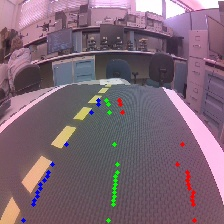

Deviation from lane center: -0.03571428571428571


In [145]:
image = cv2.imread('Test_Lane_Images/image_2.jpg')
result_img, deviation = get_lane_midline_adaptive_stable_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [146]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_sobel_only_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    # === 1. Contrast Enhancement ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. Sobel X Edge Detection ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    # Keep only bottom portion
    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]

    # Morphological closing to reduce fragmentation
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === 3. Save Debug Image ===
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)

    # === 4. Extract Contour Edge Points ===
    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    edge_pts = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            edge_pts.append((x, y))

    # === 5. Build Midline from Closest Left/Right Pairs with Slope Filtering ===
    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_dev = int(w * 0.4)
    max_slope_deg = 30  # suppress sudden angle jumps

    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        row_pts = [x for (x, yy) in edge_pts if abs(yy - y) <= 2]
        if len(row_pts) < 2:
            continue
        row_pts_sorted = sorted(row_pts, key=lambda x: abs(x - mid_x))
        x_left = next((x for x in row_pts_sorted if x < mid_x and abs(x - mid_x) <= max_dev), None)
        x_right = next((x for x in row_pts_sorted if x > mid_x and abs(x - mid_x) <= max_dev), None)

        if x_left is None or x_right is None:
            continue

        x_center = (x_left + x_right) // 2

        # Slope filtering to eliminate spurious spikes
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        # Draw debug overlay
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)   # Blue: left
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)  # Red: right

    # === 6. Smooth Midline and Draw ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)  # Green: centerline

    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 7. Compute Deviation from Center ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - mid_x) / mid_x
    else:
        deviation = 0.0

    return out_img, deviation


C:\Users\B-Dog\AppData\Local\Temp\ipykernel_27100\3832214572.py:92: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  x_smooth = medfilt(x_vals, kernel_size=5)


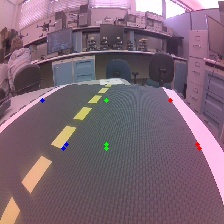

Deviation from center: -0.05357142857142857


In [152]:
image = cv2.imread('Test_Lane_Images/image_2.jpg')
result_img, deviation = get_lane_midline_sobel_only_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from center:", deviation)


In [153]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_sobel_median_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    # === 1. Contrast Boosting ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. Sobel X Edge Detection ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === 3. Debug Save ===
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)

    # === 4. Extract contour points ===
    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    edge_pts = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            edge_pts.append((x, y))

    # === 5. Overlay setup ===
    out_img = image.copy()
    if len(out_img.shape) == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_slope_deg = 30
    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        x_row = [x for (x, yy) in edge_pts if abs(yy - y) <= 2]
        if len(x_row) < 4:
            continue

        x_lefts = [x for x in x_row if x < mid_x]
        x_rights = [x for x in x_row if x > mid_x]

        if not x_lefts or not x_rights:
            continue

        x_left = int(np.median(x_lefts))
        x_right = int(np.median(x_rights))
        x_center = (x_left + x_right) // 2

        # Slope filter
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        # Draw debug overlay
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)

    # === 6. Smooth Midline ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)

    # Save overlay
    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 7. Compute deviation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - mid_x) / mid_x
    else:
        deviation = 0.0

    return out_img, deviation


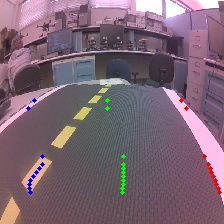

Deviation from lane center: 0.08928571428571429


In [159]:
image = cv2.imread('Test_Lane_Images/image_2.jpg')
result_img, deviation = get_lane_midline_sobel_median_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [160]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_sobel_centerband_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    # === 1. Gamma Correction ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. Sobel Edge Detection (X Gradient) ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === 3. Save Debug Images ===
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)

    # === 4. Extract edge points ===
    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    edge_pts = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for pt in cnt:
            x, y = pt[0]
            edge_pts.append((x, y))

    # === 5. Setup Overlay ===
    out_img = image.copy()
    if out_img.ndim == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_deviation_from_center = int(w * 0.45)  # trusted lane band
    max_slope_deg = 30
    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        x_row = [x for (x, yy) in edge_pts if abs(yy - y) <= 2]
        if len(x_row) < 4:
            continue

        # Filter points within "trusted band"
        x_lefts = [x for x in x_row if x < mid_x and abs(x - mid_x) <= max_deviation_from_center]
        x_rights = [x for x in x_row if x > mid_x and abs(x - mid_x) <= max_deviation_from_center]

        if not x_lefts or not x_rights:
            continue

        x_left = int(np.median(x_lefts))
        x_right = int(np.median(x_rights))
        x_center = (x_left + x_right) // 2

        # Slope filtering
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        # Draw for debug
        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)

    # === 6. Smooth Midline and Draw ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)

    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 7. Compute Deviation from Image Center ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - mid_x) / mid_x
    else:
        deviation = 0.0

    return out_img, deviation


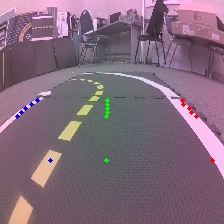

Deviation from center: -0.05357142857142857


In [164]:
image = cv2.imread('Test_Lane_Images/image_3.jpg')
result_img, deviation = get_lane_midline_sobel_centerband_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from center:", deviation)


In [165]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_hybrid_hsv_sobel_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    # === 1. Contrast Boost ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. Sobel X Edge Detection ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === 3. HSV Yellow Mask for Left Lane Only ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])
    mask_yellow = cv2.inRange(hsv, (15, 50, 50), (40, 255, 255))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # Apply Sobel ∩ HSV for left lane only
    yellow_sobel = cv2.bitwise_and(mask_yellow, sobel_mask)
    left_pts = []
    right_pts = []

    # === 4. Contour Extraction ===
    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for x, y in cnt[:, 0, :]:
            if y < int(h * 0.45):
                continue
            # Left edge: only include if in yellow ∩ sobel
            if x < mid_x and yellow_sobel[y, x] > 0:
                left_pts.append((x, y))
            # Right edge: include all Sobel-only detections
            elif x > mid_x:
                right_pts.append((x, y))

    # === 5. Midpoint Computation with Slope Filter ===
    out_img = image.copy()
    if out_img.ndim == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_slope_deg = 30
    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        x_lefts = [x for (x, yy) in left_pts if abs(yy - y) <= 2]
        x_rights = [x for (x, yy) in right_pts if abs(yy - y) <= 2]
        if not x_lefts or not x_rights:
            continue
        x_left = int(np.median(x_lefts))
        x_right = int(np.median(x_rights))
        x_center = (x_left + x_right) // 2

        # Slope filter
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)  # Blue
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1) # Red

    # === 6. Midline Smoothing ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)

    # === 7. Save Debug Images ===
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
    cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)
    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 8. Deviation Calculation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - mid_x) / mid_x
    else:
        deviation = 0.0

    return out_img, deviation


C:\Users\B-Dog\AppData\Local\Temp\ipykernel_27100\970959642.py:94: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  x_smooth = medfilt(x_vals, kernel_size=5)


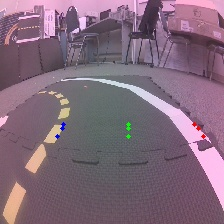

Deviation from lane center: 0.14285714285714285


In [170]:
image = cv2.imread('Test_Lane_Images/image_4.jpg')
result_img, deviation = get_lane_midline_hybrid_hsv_sobel_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from lane center:", deviation)


In [171]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_hybrid_hsv_sobel_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    # === 1. Gamma Correction ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. Sobel X Edge Detection ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === 3. HSV Yellow Mask (broadened for reddish tint) ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])
    mask_yellow = cv2.inRange(hsv, (10, 30, 40), (45, 255, 255))  # updated!
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    yellow_sobel = cv2.bitwise_and(mask_yellow, sobel_mask)

    left_pts = []
    right_pts = []

    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for x, y in cnt[:, 0, :]:
            if y < int(h * 0.45):
                continue
            if x < mid_x and yellow_sobel[y, x] > 0:
                left_pts.append((x, y))
            elif x > mid_x:
                right_pts.append((x, y))

    out_img = image.copy()
    if out_img.ndim == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_slope_deg = 30
    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        x_lefts = [x for (x, yy) in left_pts if abs(yy - y) <= 2]
        x_rights = [x for (x, yy) in right_pts if abs(yy - y) <= 2]
        if not x_lefts or not x_rights:
            continue
        x_left = int(np.median(x_lefts))
        x_right = int(np.median(x_rights))
        x_center = (x_left + x_right) // 2

        # Slope filtering
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)

    # === Midline smoothing ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)

    # === Save Debug Images ===
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
    cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)
    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === Final Deviation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - mid_x) / mid_x
    else:
        deviation = 0.0

    return out_img, deviation


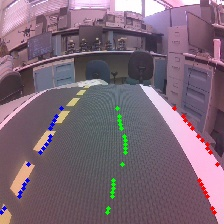

Deviation from center: -0.044642857142857144


In [179]:
image = cv2.imread('Test_Lane_Images/image_1.jpg')
result_img, deviation = get_lane_midline_hybrid_hsv_sobel_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from center:", deviation)


In [180]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_inner_edges_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    # === 1. Contrast boost ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. Sobel X ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === 3. Yellow HSV mask (for left lane only) ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])
    mask_yellow = cv2.inRange(hsv, (10, 30, 40), (45, 255, 255))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)
    yellow_sobel = cv2.bitwise_and(mask_yellow, sobel_mask)

    # === 4. Extract left (yellow) & right (sobel) edge points ===
    left_pts = []
    right_pts = []

    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for x, y in cnt[:, 0, :]:
            if y < int(h * 0.45):
                continue
            if x < mid_x and yellow_sobel[y, x] > 0:
                left_pts.append((x, y))
            elif x > mid_x:
                right_pts.append((x, y))

    # === 5. Midpoint calculation using inner-edge logic ===
    out_img = image.copy()
    if out_img.ndim == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_slope_deg = 30
    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        # Left: pick rightmost yellow pixel
        x_lefts = [x for (x, yy) in left_pts if abs(yy - y) <= 2]
        x_rights = [x for (x, yy) in right_pts if abs(yy - y) <= 2]

        if not x_lefts or not x_rights:
            continue

        x_left = max(x_lefts)
        x_right = min(x_rights)
        x_center = (x_left + x_right) // 2

        # Slope filter
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        cv2.circle(out_img, (x_left, y), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (x_right, y), 2, (0, 0, 255), -1)

    # === 6. Midline smoothing ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (x_c, y), 2, (0, 255, 0), -1)

    # === 7. Save debug images ===
    cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
    cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)
    cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)
    cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 8. Deviation from center ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - mid_x) / mid_x
    else:
        deviation = 0.0

    return out_img, deviation


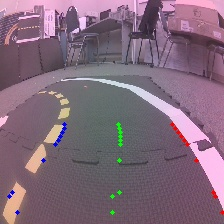

Deviation from center: 0.0


In [190]:
image = cv2.imread('Test_Lane_Images/image_4.jpg')
result_img, deviation = get_lane_midline_inner_edges_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from center:", deviation)


In [191]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def get_lane_midline_inner_edges_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    # === 1. Gamma correction ===
    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === 2. Sobel edge detection (X direction) ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === 3. HSV Yellow mask for left lane only ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])
    mask_yellow = cv2.inRange(hsv, (10, 30, 40), (45, 255, 255))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)
    yellow_sobel = cv2.bitwise_and(mask_yellow, sobel_mask)

    # === 4. Extract inner edge points ===
    left_pts = []
    right_pts = []

    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for x, y in cnt[:, 0, :]:
            if y < int(h * 0.45):
                continue
            if x < mid_x and yellow_sobel[y, x] > 0:
                left_pts.append((x, y))
            elif x > mid_x:
                right_pts.append((x, y))

    # === 5. Midline computation (only inner edges) ===
    out_img = image.copy()
    if out_img.ndim == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_slope_deg = 30
    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        x_lefts = [x for (x, yy) in left_pts if abs(yy - y) <= 2]
        x_rights = [x for (x, yy) in right_pts if abs(yy - y) <= 2]

        if not x_lefts or not x_rights:
            continue

        x_left = max(x_lefts)
        x_right = min(x_rights)
        x_center = (x_left + x_right) // 2

        # Slope filtering
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        # ✅ Cast all x/y to int for drawing
        cv2.circle(out_img, (int(x_left), int(y)), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (int(x_right), int(y)), 2, (0, 0, 255), -1)

    # === 6. Midline smoothing ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), int(y)), 2, (0, 255, 0), -1)

    # === 7. Save debug images ===
    if debug_prefix:
        cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
        cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)
        cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)
        cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === 8. Final deviation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - mid_x) / mid_x
    else:
        deviation = 0.0

    return out_img, deviation


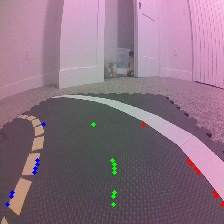

Deviation from center: 0.008928571428571428


In [196]:
image = cv2.imread('Test_Lane_Images/image_5.jpg')
result_img, deviation = get_lane_midline_inner_edges_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from center:", deviation)


In [208]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def iqr_filter(x_list):
    x = np.array(x_list)
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return [val for val in x if lower <= val <= upper]

def get_lane_midline_inner_edges_outlier_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === Sobel X edges ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === HSV yellow mask ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])
    mask_yellow = cv2.inRange(hsv, (10, 30, 40), (45, 255, 255))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)
    yellow_sobel = cv2.bitwise_and(mask_yellow, sobel_mask)

    # === Extract left (yellow ∩ sobel) and right (sobel only) points ===
    left_pts = []
    right_pts = []

    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for x, y in cnt[:, 0, :]:
            if y < int(h * 0.45):
                continue
            if x < mid_x and yellow_sobel[y, x] > 0:
                left_pts.append((x, y))
            elif x > mid_x:
                right_pts.append((x, y))

    # === Overlay image ===
    out_img = image.copy()
    if out_img.ndim == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_slope_deg = 30
    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        x_lefts = [x for (x, yy) in left_pts if abs(yy - y) <= 2]
        x_rights = [x for (x, yy) in right_pts if abs(yy - y) <= 2]

        if len(x_lefts) >= 3:
            x_lefts = iqr_filter(x_lefts)
        if len(x_rights) >= 3:
            x_rights = iqr_filter(x_rights)

        if not x_lefts or not x_rights:
            continue

        x_left = max(x_lefts)
        x_right = min(x_rights)
        x_center = (x_left + x_right) // 2

        # Slope filtering
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        # Draw edges
        cv2.circle(out_img, (int(x_left), int(y)), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (int(x_right), int(y)), 2, (0, 0, 255), -1)

    # === Midline smoothing ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), int(y)), 2, (0, 255, 0), -1)

    # === Save debug outputs ===
    if debug_prefix:
        cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
        cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)
        cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)
        cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === Deviation computation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - mid_x) / mid_x
    else:
        deviation = 0.0

    return out_img, deviation


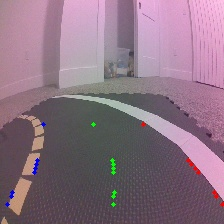

Deviation from center: 0.008928571428571428


In [209]:
image = cv2.imread('Test_Lane_Images/image_5.jpg')
result_img, deviation = get_lane_midline_inner_edges_outlier_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from center:", deviation)


In [1]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display


def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()


def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)


def iqr_filter(x_list):
    x = np.array(x_list)
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return [val for val in x if lower <= val <= upper]


def get_lane_midline_with_angle(image, debug_prefix=None, apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])
    mask_yellow = cv2.inRange(hsv, (10, 30, 40), (45, 255, 255))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)
    yellow_sobel = cv2.bitwise_and(mask_yellow, sobel_mask)

    left_pts, right_pts = [], []
    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for x, y in cnt[:, 0, :]:
            if y < int(h * 0.45):
                continue
            if x < mid_x and yellow_sobel[y, x] > 0:
                left_pts.append((x, y))
            elif x > mid_x:
                right_pts.append((x, y))

    out_img = image.copy()
    if out_img.ndim == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_slope_deg = 30
    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        x_lefts = [x for (x, yy) in left_pts if abs(yy - y) <= 2]
        x_rights = [x for (x, yy) in right_pts if abs(yy - y) <= 2]

        if len(x_lefts) >= 3:
            x_lefts = iqr_filter(x_lefts)
        if len(x_rights) >= 3:
            x_rights = iqr_filter(x_rights)

        if not x_lefts or not x_rights:
            continue

        x_left = max(x_lefts)
        x_right = min(x_rights)
        x_center = (x_left + x_right) // 2

        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        cv2.circle(out_img, (int(x_left), int(y)), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (int(x_right), int(y)), 2, (0, 0, 255), -1)

    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), int(y)), 2, (0, 255, 0), -1)

    # === Lookahead angle ===
    if mid_pts:
        idx = int(len(mid_pts) * 0.5)
        lx, ly = mid_pts[idx]
        dx = lx - mid_x
        dy = h - ly
        lookahead_angle = np.arctan2(dx, dy)  # radians
    else:
        lookahead_angle = 0.0

    if debug_prefix:
        cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
        cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)
        cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)
        cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    return out_img, lookahead_angle
